## Fixed Data:

In [1]:
pip install fredapi

In [14]:
import pandas as pd
from fredapi import Fred
from tqdm import tqdm


API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'TransactionCount': '/v1/metrics/transactions/count',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### <font color='red'> It seems the risk-free rate is daily rate. is it in percentage or in unit 1? need to adjust to weekly rate and select Monday

## Get Multiple Attributes for Multiple Coins:

In [3]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    print(f"Pulling {coin}'s {feature}")

    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [4]:
# Effect:
PullData('BTC', 'Price').head()

Pulling BTC's Price


,Date,Price
0,2010-07-12,0.08584
1,2010-07-19,0.05050
2,2010-07-26,0.06110
3,2010-08-02,0.06090
4,2010-08-09,0.06529


In [5]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from tqdm import tqdm
    from fredapi import Fred

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Data Pull
    for i in tqdm(coinList):
        print(f"\nStart Pulling {i}'s data:")

        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Get data
        for j in list(endPoints.keys()):
            locals()[frameName].append(PullData(i,
                                                j))

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        print(f"\n{i} data successfully pulled\n")
    print('All Frames Merged')
    print('\nALL DATA SUCCESSFULLY PULLED!')

    return fullFrame


In [6]:
# Effect:
df = PullStart(symbolListShort)
df

  0%|          | 0/3 [00:00<?, ?it/s]


Start Pulling BTC's data:
Pulling BTC's Price
Pulling BTC's MarketCap
Pulling BTC's TransactionCount
Pulling BTC's ActiveAddress


 33%|███▎      | 1/3 [00:01<00:03,  1.94s/it]


BTC data successfully pulled


Start Pulling ETH's data:
Pulling ETH's Price
Pulling ETH's MarketCap
Pulling ETH's TransactionCount
Pulling ETH's ActiveAddress


 67%|██████▋   | 2/3 [00:03<00:01,  1.87s/it]


ETH data successfully pulled


Start Pulling LTC's data:
Pulling LTC's Price
Pulling LTC's MarketCap
Pulling LTC's TransactionCount
Pulling LTC's ActiveAddress


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


LTC data successfully pulled

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!


,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,NaN,0,0.0004,BTC
1,2009-01-05,NaN,NaN,NaN,0,0.0005,BTC
2,2009-01-12,NaN,NaN,19.0,34,0.0004,BTC
3,2009-01-19,NaN,NaN,9.0,63,NaN,BTC
4,2009-01-26,NaN,NaN,5.0,61,0.0002,BTC
...,...,...,...,...,...,...,...
1595,2022-03-28,128.926292,9.023978e+09,807733.0,1566202,0.0019,LTC
1596,2022-04-04,111.343007,7.798857e+09,841901.0,1576883,0.0018,LTC
1597,2022-04-11,109.018201,7.641529e+09,832321.0,1652475,0.0022,LTC
1598,2022-04-18,104.648982,7.340578e+09,830602.0,1562294,0.0038,LTC


## <font color='red'> Imputation for NA values -- to be resolved

## Calculate Returns

In [54]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append('Return'))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
        temp = segment[-53:-1].reset_index().drop('index', axis=1)
        segment = segment[-52:].reset_index().drop('index', axis=1)
        segment['Return'] = (segment['Price'] - temp['Price'])/temp['Price']
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
    fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]
    return fullFrame

In [55]:
# Effect:

AddReturn(df)

,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset,Return,ExcessReturn
0,2021-05-03,58218.566077,1.088991e+12,2038316.0,6622607,0.0002,BTC,0.028357,0.028157
1,2021-05-10,46406.331544,8.683518e+11,1908851.0,6062366,0.0002,BTC,-0.202895,-0.203095
2,2021-05-17,34888.678313,6.530094e+11,1607054.0,4960283,0.0000,BTC,-0.248191,-0.248191
3,2021-05-24,35639.981455,6.672647e+11,1508758.0,4981835,0.0001,BTC,0.021534,0.021434
4,2021-05-31,35797.422390,6.704378e+11,1582789.0,4893673,NaN,BTC,0.004418,NaN
...,...,...,...,...,...,...,...,...,...
151,2022-03-28,128.926292,9.023978e+09,807733.0,1566202,0.0019,LTC,-0.002438,-0.004338
152,2022-04-04,111.343007,7.798857e+09,841901.0,1576883,0.0018,LTC,-0.136382,-0.138182
153,2022-04-11,109.018201,7.641529e+09,832321.0,1652475,0.0022,LTC,-0.020880,-0.023080
154,2022-04-18,104.648982,7.340578e+09,830602.0,1562294,0.0038,LTC,-0.040078,-0.043878


## Initialize

In [9]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

  0%|          | 0/124 [00:00<?, ?it/s]


Start Pulling BTC's data:
Pulling BTC's Price
Pulling BTC's MarketCap
Pulling BTC's TransactionCount
Pulling BTC's ActiveAddress


  1%|          | 1/124 [00:02<04:32,  2.22s/it]


BTC data successfully pulled


Start Pulling ETH's data:
Pulling ETH's Price
Pulling ETH's MarketCap
Pulling ETH's TransactionCount
Pulling ETH's ActiveAddress


  2%|▏         | 2/124 [00:04<04:11,  2.06s/it]


ETH data successfully pulled


Start Pulling LTC's data:
Pulling LTC's Price
Pulling LTC's MarketCap
Pulling LTC's TransactionCount
Pulling LTC's ActiveAddress


  2%|▏         | 3/124 [00:06<04:00,  1.98s/it]


LTC data successfully pulled


Start Pulling AAVE's data:
Pulling AAVE's Price
Pulling AAVE's MarketCap
Pulling AAVE's TransactionCount
Pulling AAVE's ActiveAddress


  3%|▎         | 4/124 [00:07<03:46,  1.89s/it]


AAVE data successfully pulled


Start Pulling ABT's data:
Pulling ABT's Price
Pulling ABT's MarketCap
Pulling ABT's TransactionCount
Pulling ABT's ActiveAddress


  4%|▍         | 5/124 [00:08<03:11,  1.61s/it]


ABT data successfully pulled


Start Pulling AMPL's data:
Pulling AMPL's Price
Pulling AMPL's MarketCap
Pulling AMPL's TransactionCount
Pulling AMPL's ActiveAddress


  5%|▍         | 6/124 [00:10<02:57,  1.51s/it]


AMPL data successfully pulled


Start Pulling ANT's data:
Pulling ANT's Price
Pulling ANT's MarketCap
Pulling ANT's TransactionCount
Pulling ANT's ActiveAddress


  6%|▌         | 7/124 [00:11<02:52,  1.47s/it]


ANT data successfully pulled


Start Pulling ARMOR's data:
Pulling ARMOR's Price
Pulling ARMOR's MarketCap
Pulling ARMOR's TransactionCount
Pulling ARMOR's ActiveAddress


  6%|▋         | 8/124 [00:12<02:33,  1.32s/it]


ARMOR data successfully pulled


Start Pulling BADGER's data:
Pulling BADGER's Price
Pulling BADGER's MarketCap
Pulling BADGER's TransactionCount
Pulling BADGER's ActiveAddress


  7%|▋         | 9/124 [00:14<02:42,  1.42s/it]


BADGER data successfully pulled


Start Pulling BAL's data:
Pulling BAL's Price
Pulling BAL's MarketCap
Pulling BAL's TransactionCount
Pulling BAL's ActiveAddress


  8%|▊         | 10/124 [00:15<02:40,  1.41s/it]


BAL data successfully pulled


Start Pulling BAND's data:
Pulling BAND's Price
Pulling BAND's MarketCap
Pulling BAND's TransactionCount
Pulling BAND's ActiveAddress


  9%|▉         | 11/124 [00:16<02:33,  1.36s/it]


BAND data successfully pulled


Start Pulling BAT's data:
Pulling BAT's Price
Pulling BAT's MarketCap
Pulling BAT's TransactionCount
Pulling BAT's ActiveAddress


 10%|▉         | 12/124 [00:18<02:30,  1.34s/it]


BAT data successfully pulled


Start Pulling BIX's data:
Pulling BIX's Price
Pulling BIX's MarketCap
Pulling BIX's TransactionCount
Pulling BIX's ActiveAddress


 10%|█         | 13/124 [00:19<02:41,  1.46s/it]


BIX data successfully pulled


Start Pulling BNT's data:
Pulling BNT's Price
Pulling BNT's MarketCap
Pulling BNT's TransactionCount
Pulling BNT's ActiveAddress


 11%|█▏        | 14/124 [00:21<02:31,  1.38s/it]


BNT data successfully pulled


Start Pulling BOND's data:
Pulling BOND's Price
Pulling BOND's MarketCap
Pulling BOND's TransactionCount
Pulling BOND's ActiveAddress


 12%|█▏        | 15/124 [00:22<02:38,  1.46s/it]


BOND data successfully pulled


Start Pulling BRD's data:
Pulling BRD's Price
Pulling BRD's MarketCap
Pulling BRD's TransactionCount
Pulling BRD's ActiveAddress


 13%|█▎        | 16/124 [00:23<02:25,  1.35s/it]


BRD data successfully pulled


Start Pulling BUSD's data:
Pulling BUSD's Price
Pulling BUSD's MarketCap
Pulling BUSD's TransactionCount
Pulling BUSD's ActiveAddress


 14%|█▎        | 17/124 [00:24<02:17,  1.28s/it]


BUSD data successfully pulled


Start Pulling BZRX's data:
Pulling BZRX's Price
Pulling BZRX's MarketCap
Pulling BZRX's TransactionCount
Pulling BZRX's ActiveAddress


 15%|█▍        | 18/124 [00:26<02:07,  1.21s/it]


BZRX data successfully pulled


Start Pulling CELR's data:
Pulling CELR's Price
Pulling CELR's MarketCap
Pulling CELR's TransactionCount
Pulling CELR's ActiveAddress


 15%|█▌        | 19/124 [00:27<02:01,  1.16s/it]


CELR data successfully pulled


Start Pulling CHSB's data:
Pulling CHSB's Price
Pulling CHSB's MarketCap
Pulling CHSB's TransactionCount
Pulling CHSB's ActiveAddress


 16%|█▌        | 20/124 [00:28<01:56,  1.12s/it]


CHSB data successfully pulled


Start Pulling CND's data:
Pulling CND's Price
Pulling CND's MarketCap
Pulling CND's TransactionCount
Pulling CND's ActiveAddress


 17%|█▋        | 21/124 [00:29<01:54,  1.12s/it]


CND data successfully pulled


Start Pulling COMP's data:
Pulling COMP's Price
Pulling COMP's MarketCap
Pulling COMP's TransactionCount
Pulling COMP's ActiveAddress


 18%|█▊        | 22/124 [00:30<02:00,  1.18s/it]


COMP data successfully pulled


Start Pulling CREAM's data:
Pulling CREAM's Price
Pulling CREAM's MarketCap
Pulling CREAM's TransactionCount
Pulling CREAM's ActiveAddress


 19%|█▊        | 23/124 [00:31<02:00,  1.19s/it]


CREAM data successfully pulled


Start Pulling CRO's data:
Pulling CRO's Price
Pulling CRO's MarketCap
Pulling CRO's TransactionCount
Pulling CRO's ActiveAddress


 19%|█▉        | 24/124 [00:32<01:55,  1.15s/it]


CRO data successfully pulled


Start Pulling CRV's data:
Pulling CRV's Price
Pulling CRV's MarketCap
Pulling CRV's TransactionCount
Pulling CRV's ActiveAddress


 20%|██        | 25/124 [00:34<01:56,  1.17s/it]


CRV data successfully pulled


Start Pulling CVC's data:
Pulling CVC's Price
Pulling CVC's MarketCap
Pulling CVC's TransactionCount
Pulling CVC's ActiveAddress


 21%|██        | 26/124 [00:35<01:59,  1.22s/it]


CVC data successfully pulled


Start Pulling CVP's data:
Pulling CVP's Price
Pulling CVP's MarketCap
Pulling CVP's TransactionCount
Pulling CVP's ActiveAddress


 22%|██▏       | 27/124 [00:36<01:55,  1.20s/it]


CVP data successfully pulled


Start Pulling DAI's data:
Pulling DAI's Price
Pulling DAI's MarketCap
Pulling DAI's TransactionCount
Pulling DAI's ActiveAddress


 23%|██▎       | 28/124 [00:37<02:00,  1.26s/it]


DAI data successfully pulled


Start Pulling DDX's data:
Pulling DDX's Price
Pulling DDX's MarketCap
Pulling DDX's TransactionCount
Pulling DDX's ActiveAddress


 23%|██▎       | 29/124 [00:39<02:00,  1.27s/it]


DDX data successfully pulled


Start Pulling DENT's data:
Pulling DENT's Price
Pulling DENT's MarketCap
Pulling DENT's TransactionCount
Pulling DENT's ActiveAddress


 24%|██▍       | 30/124 [00:40<01:54,  1.21s/it]


DENT data successfully pulled


Start Pulling DGX's data:
Pulling DGX's Price
Pulling DGX's MarketCap
Pulling DGX's TransactionCount
Pulling DGX's ActiveAddress


 25%|██▌       | 31/124 [00:41<01:48,  1.17s/it]


DGX data successfully pulled


Start Pulling DHT's data:
Pulling DHT's Price
Pulling DHT's MarketCap
Pulling DHT's TransactionCount
Pulling DHT's ActiveAddress


 26%|██▌       | 32/124 [00:42<01:43,  1.12s/it]


DHT data successfully pulled


Start Pulling DMG's data:
Pulling DMG's Price
Pulling DMG's MarketCap
Pulling DMG's TransactionCount
Pulling DMG's ActiveAddress


 27%|██▋       | 33/124 [00:43<01:39,  1.10s/it]


DMG data successfully pulled


Start Pulling DODO's data:
Pulling DODO's Price
Pulling DODO's MarketCap
Pulling DODO's TransactionCount
Pulling DODO's ActiveAddress


 27%|██▋       | 34/124 [00:44<01:37,  1.08s/it]


DODO data successfully pulled


Start Pulling DOUGH's data:
Pulling DOUGH's Price
Pulling DOUGH's MarketCap
Pulling DOUGH's TransactionCount
Pulling DOUGH's ActiveAddress


 28%|██▊       | 35/124 [00:45<01:39,  1.12s/it]


DOUGH data successfully pulled


Start Pulling DRGN's data:
Pulling DRGN's Price
Pulling DRGN's MarketCap
Pulling DRGN's TransactionCount
Pulling DRGN's ActiveAddress


 29%|██▉       | 36/124 [00:46<01:42,  1.16s/it]


DRGN data successfully pulled


Start Pulling ELF's data:
Pulling ELF's Price
Pulling ELF's MarketCap
Pulling ELF's TransactionCount
Pulling ELF's ActiveAddress


 30%|██▉       | 37/124 [00:47<01:39,  1.14s/it]


ELF data successfully pulled


Start Pulling ENG's data:
Pulling ENG's Price
Pulling ENG's MarketCap
Pulling ENG's TransactionCount
Pulling ENG's ActiveAddress


 31%|███       | 38/124 [00:49<01:47,  1.25s/it]


ENG data successfully pulled


Start Pulling ENJ's data:
Pulling ENJ's Price
Pulling ENJ's MarketCap
Pulling ENJ's TransactionCount
Pulling ENJ's ActiveAddress


 31%|███▏      | 39/124 [00:50<01:43,  1.21s/it]


ENJ data successfully pulled


Start Pulling EURS's data:
Pulling EURS's Price
Pulling EURS's MarketCap
Pulling EURS's TransactionCount
Pulling EURS's ActiveAddress


 32%|███▏      | 40/124 [00:51<01:37,  1.17s/it]


EURS data successfully pulled


Start Pulling FET's data:
Pulling FET's Price
Pulling FET's MarketCap
Pulling FET's TransactionCount
Pulling FET's ActiveAddress


 33%|███▎      | 41/124 [00:52<01:34,  1.14s/it]


FET data successfully pulled


Start Pulling FTT's data:
Pulling FTT's Price
Pulling FTT's MarketCap
Pulling FTT's TransactionCount
Pulling FTT's ActiveAddress


 34%|███▍      | 42/124 [00:53<01:31,  1.12s/it]


FTT data successfully pulled


Start Pulling FUN's data:
Pulling FUN's Price
Pulling FUN's MarketCap
Pulling FUN's TransactionCount
Pulling FUN's ActiveAddress


 35%|███▍      | 43/124 [00:54<01:29,  1.11s/it]


FUN data successfully pulled


Start Pulling GNO's data:
Pulling GNO's Price
Pulling GNO's MarketCap
Pulling GNO's TransactionCount
Pulling GNO's ActiveAddress


 35%|███▌      | 44/124 [00:56<01:28,  1.11s/it]


GNO data successfully pulled


Start Pulling GUSD's data:
Pulling GUSD's Price
Pulling GUSD's MarketCap
Pulling GUSD's TransactionCount
Pulling GUSD's ActiveAddress


 36%|███▋      | 45/124 [00:57<01:26,  1.10s/it]


GUSD data successfully pulled


Start Pulling HEGIC's data:
Pulling HEGIC's Price
Pulling HEGIC's MarketCap
Pulling HEGIC's TransactionCount
Pulling HEGIC's ActiveAddress


 37%|███▋      | 46/124 [00:58<01:27,  1.12s/it]


HEGIC data successfully pulled


Start Pulling HOT's data:
Pulling HOT's Price
Pulling HOT's MarketCap
Pulling HOT's TransactionCount
Pulling HOT's ActiveAddress


 38%|███▊      | 47/124 [00:59<01:32,  1.20s/it]


HOT data successfully pulled


Start Pulling HPT's data:
Pulling HPT's Price
Pulling HPT's MarketCap
Pulling HPT's TransactionCount
Pulling HPT's ActiveAddress


 39%|███▊      | 48/124 [01:00<01:28,  1.16s/it]


HPT data successfully pulled


Start Pulling HT's data:
Pulling HT's Price
Pulling HT's MarketCap
Pulling HT's TransactionCount
Pulling HT's ActiveAddress


 40%|███▉      | 49/124 [01:02<01:33,  1.25s/it]


HT data successfully pulled


Start Pulling HUSD's data:
Pulling HUSD's Price
Pulling HUSD's MarketCap
Pulling HUSD's TransactionCount
Pulling HUSD's ActiveAddress


 40%|████      | 50/124 [01:03<01:27,  1.19s/it]


HUSD data successfully pulled


Start Pulling INDEX's data:
Pulling INDEX's Price
Pulling INDEX's MarketCap
Pulling INDEX's TransactionCount
Pulling INDEX's ActiveAddress


 41%|████      | 51/124 [01:04<01:26,  1.18s/it]


INDEX data successfully pulled


Start Pulling KCS's data:
Pulling KCS's Price
Pulling KCS's MarketCap
Pulling KCS's TransactionCount
Pulling KCS's ActiveAddress


 42%|████▏     | 52/124 [01:05<01:28,  1.22s/it]


KCS data successfully pulled


Start Pulling LAMB's data:
Pulling LAMB's Price
Pulling LAMB's MarketCap
Pulling LAMB's TransactionCount
Pulling LAMB's ActiveAddress


 43%|████▎     | 53/124 [01:07<01:43,  1.46s/it]


LAMB data successfully pulled


Start Pulling LBA's data:
Pulling LBA's Price
Pulling LBA's MarketCap
Pulling LBA's TransactionCount
Pulling LBA's ActiveAddress


 44%|████▎     | 54/124 [01:09<01:42,  1.47s/it]


LBA data successfully pulled


Start Pulling LDO's data:
Pulling LDO's Price
Pulling LDO's MarketCap
Pulling LDO's TransactionCount
Pulling LDO's ActiveAddress


 44%|████▍     | 55/124 [01:10<01:31,  1.33s/it]


LDO data successfully pulled


Start Pulling LEO's data:
Pulling LEO's Price
Pulling LEO's MarketCap
Pulling LEO's TransactionCount
Pulling LEO's ActiveAddress


 45%|████▌     | 56/124 [01:11<01:25,  1.26s/it]


LEO data successfully pulled


Start Pulling LINK's data:
Pulling LINK's Price
Pulling LINK's MarketCap
Pulling LINK's TransactionCount
Pulling LINK's ActiveAddress


 46%|████▌     | 57/124 [01:12<01:21,  1.21s/it]


LINK data successfully pulled


Start Pulling LOOM's data:
Pulling LOOM's Price
Pulling LOOM's MarketCap
Pulling LOOM's TransactionCount
Pulling LOOM's ActiveAddress


 47%|████▋     | 58/124 [01:13<01:17,  1.18s/it]


LOOM data successfully pulled


Start Pulling LRC's data:
Pulling LRC's Price
Pulling LRC's MarketCap
Pulling LRC's TransactionCount
Pulling LRC's ActiveAddress


 48%|████▊     | 59/124 [01:14<01:15,  1.16s/it]


LRC data successfully pulled


Start Pulling MANA's data:
Pulling MANA's Price
Pulling MANA's MarketCap
Pulling MANA's TransactionCount
Pulling MANA's ActiveAddress


 48%|████▊     | 60/124 [01:16<01:20,  1.26s/it]


MANA data successfully pulled


Start Pulling MATIC's data:
Pulling MATIC's Price
Pulling MATIC's MarketCap
Pulling MATIC's TransactionCount
Pulling MATIC's ActiveAddress


 49%|████▉     | 61/124 [01:17<01:18,  1.24s/it]


MATIC data successfully pulled


Start Pulling MCB's data:
Pulling MCB's Price
Pulling MCB's MarketCap
Pulling MCB's TransactionCount
Pulling MCB's ActiveAddress


 50%|█████     | 62/124 [01:18<01:16,  1.23s/it]


MCB data successfully pulled


Start Pulling MCO's data:
Pulling MCO's Price
Pulling MCO's MarketCap
Pulling MCO's TransactionCount
Pulling MCO's ActiveAddress


 51%|█████     | 63/124 [01:19<01:16,  1.25s/it]


MCO data successfully pulled


Start Pulling MFT's data:
Pulling MFT's Price
Pulling MFT's MarketCap
Pulling MFT's TransactionCount
Pulling MFT's ActiveAddress


 52%|█████▏    | 64/124 [01:21<01:16,  1.27s/it]


MFT data successfully pulled


Start Pulling MIR's data:
Pulling MIR's Price
Pulling MIR's MarketCap
Pulling MIR's TransactionCount
Pulling MIR's ActiveAddress


 52%|█████▏    | 65/124 [01:22<01:09,  1.18s/it]


MIR data successfully pulled


Start Pulling MKR's data:
Pulling MKR's Price
Pulling MKR's MarketCap
Pulling MKR's TransactionCount
Pulling MKR's ActiveAddress


 53%|█████▎    | 66/124 [01:23<01:07,  1.16s/it]


MKR data successfully pulled


Start Pulling MLN's data:
Pulling MLN's Price
Pulling MLN's MarketCap
Pulling MLN's TransactionCount
Pulling MLN's ActiveAddress


 54%|█████▍    | 67/124 [01:24<01:10,  1.24s/it]


MLN data successfully pulled


Start Pulling MTA's data:
Pulling MTA's Price
Pulling MTA's MarketCap
Pulling MTA's TransactionCount
Pulling MTA's ActiveAddress


 55%|█████▍    | 68/124 [01:26<01:14,  1.33s/it]


MTA data successfully pulled


Start Pulling MTL's data:
Pulling MTL's Price
Pulling MTL's MarketCap
Pulling MTL's TransactionCount
Pulling MTL's ActiveAddress


 56%|█████▌    | 69/124 [01:27<01:10,  1.28s/it]


MTL data successfully pulled


Start Pulling MX's data:
Pulling MX's Price
Pulling MX's MarketCap
Pulling MX's TransactionCount
Pulling MX's ActiveAddress


 56%|█████▋    | 70/124 [01:28<01:08,  1.27s/it]


MX data successfully pulled


Start Pulling NDX's data:
Pulling NDX's Price
Pulling NDX's MarketCap
Pulling NDX's TransactionCount
Pulling NDX's ActiveAddress


 57%|█████▋    | 71/124 [01:29<01:04,  1.23s/it]


NDX data successfully pulled


Start Pulling NEXO's data:
Pulling NEXO's Price
Pulling NEXO's MarketCap
Pulling NEXO's TransactionCount
Pulling NEXO's ActiveAddress


 58%|█████▊    | 72/124 [01:31<01:05,  1.26s/it]


NEXO data successfully pulled


Start Pulling NFTX's data:
Pulling NFTX's Price
Pulling NFTX's MarketCap
Pulling NFTX's TransactionCount
Pulling NFTX's ActiveAddress


 59%|█████▉    | 73/124 [01:32<01:00,  1.18s/it]


NFTX data successfully pulled


Start Pulling NMR's data:
Pulling NMR's Price
Pulling NMR's MarketCap
Pulling NMR's TransactionCount
Pulling NMR's ActiveAddress


 60%|█████▉    | 74/124 [01:33<00:58,  1.16s/it]


NMR data successfully pulled


Start Pulling Nsure's data:
Pulling Nsure's Price
Pulling Nsure's MarketCap
Pulling Nsure's TransactionCount
Pulling Nsure's ActiveAddress


 60%|██████    | 75/124 [01:34<00:58,  1.20s/it]


Nsure data successfully pulled


Start Pulling OCEAN's data:
Pulling OCEAN's Price
Pulling OCEAN's MarketCap
Pulling OCEAN's TransactionCount
Pulling OCEAN's ActiveAddress


 61%|██████▏   | 76/124 [01:35<00:55,  1.17s/it]


OCEAN data successfully pulled


Start Pulling OKB's data:
Pulling OKB's Price
Pulling OKB's MarketCap
Pulling OKB's TransactionCount
Pulling OKB's ActiveAddress


 62%|██████▏   | 77/124 [01:36<00:54,  1.15s/it]


OKB data successfully pulled


Start Pulling OMG's data:
Pulling OMG's Price
Pulling OMG's MarketCap
Pulling OMG's TransactionCount
Pulling OMG's ActiveAddress


 63%|██████▎   | 78/124 [01:38<00:56,  1.22s/it]


OMG data successfully pulled


Start Pulling PAY's data:
Pulling PAY's Price
Pulling PAY's MarketCap
Pulling PAY's TransactionCount
Pulling PAY's ActiveAddress


 64%|██████▎   | 79/124 [01:39<00:54,  1.20s/it]


PAY data successfully pulled


Start Pulling PERP's data:
Pulling PERP's Price
Pulling PERP's MarketCap
Pulling PERP's TransactionCount
Pulling PERP's ActiveAddress


 65%|██████▍   | 80/124 [01:40<00:50,  1.14s/it]


PERP data successfully pulled


Start Pulling PICKLE's data:
Pulling PICKLE's Price
Pulling PICKLE's MarketCap
Pulling PICKLE's TransactionCount
Pulling PICKLE's ActiveAddress


 65%|██████▌   | 81/124 [01:41<00:47,  1.11s/it]


PICKLE data successfully pulled


Start Pulling PNK's data:
Pulling PNK's Price
Pulling PNK's MarketCap
Pulling PNK's TransactionCount
Pulling PNK's ActiveAddress


 66%|██████▌   | 82/124 [01:42<00:49,  1.17s/it]


PNK data successfully pulled


Start Pulling PNT's data:
Pulling PNT's Price
Pulling PNT's MarketCap
Pulling PNT's TransactionCount
Pulling PNT's ActiveAddress


 67%|██████▋   | 83/124 [01:43<00:50,  1.23s/it]


PNT data successfully pulled


Start Pulling POLY's data:
Pulling POLY's Price
Pulling POLY's MarketCap
Pulling POLY's TransactionCount
Pulling POLY's ActiveAddress


 68%|██████▊   | 84/124 [01:45<00:48,  1.20s/it]


POLY data successfully pulled


Start Pulling POWR's data:
Pulling POWR's Price
Pulling POWR's MarketCap
Pulling POWR's TransactionCount
Pulling POWR's ActiveAddress


 69%|██████▊   | 85/124 [01:46<00:46,  1.19s/it]


POWR data successfully pulled


Start Pulling PPT's data:
Pulling PPT's Price
Pulling PPT's MarketCap
Pulling PPT's TransactionCount
Pulling PPT's ActiveAddress


 69%|██████▉   | 86/124 [01:47<00:44,  1.17s/it]


PPT data successfully pulled


Start Pulling QASH's data:
Pulling QASH's Price
Pulling QASH's MarketCap
Pulling QASH's TransactionCount
Pulling QASH's ActiveAddress


 70%|███████   | 87/124 [01:48<00:46,  1.27s/it]


QASH data successfully pulled


Start Pulling QKC's data:
Pulling QKC's Price
Pulling QKC's MarketCap
Pulling QKC's TransactionCount
Pulling QKC's ActiveAddress


 71%|███████   | 88/124 [01:49<00:44,  1.22s/it]


QKC data successfully pulled


Start Pulling QNT's data:
Pulling QNT's Price
Pulling QNT's MarketCap
Pulling QNT's TransactionCount
Pulling QNT's ActiveAddress


 72%|███████▏  | 89/124 [01:51<00:43,  1.25s/it]


QNT data successfully pulled


Start Pulling RDN's data:
Pulling RDN's Price
Pulling RDN's MarketCap
Pulling RDN's TransactionCount
Pulling RDN's ActiveAddress


 73%|███████▎  | 90/124 [01:52<00:42,  1.25s/it]


RDN data successfully pulled


Start Pulling REN's data:
Pulling REN's Price
Pulling REN's MarketCap
Pulling REN's TransactionCount
Pulling REN's ActiveAddress


 73%|███████▎  | 91/124 [01:53<00:39,  1.21s/it]


REN data successfully pulled


Start Pulling REP's data:
Pulling REP's Price
Pulling REP's MarketCap
Pulling REP's TransactionCount
Pulling REP's ActiveAddress


 74%|███████▍  | 92/124 [01:54<00:40,  1.25s/it]


REP data successfully pulled


Start Pulling RLC's data:
Pulling RLC's Price
Pulling RLC's MarketCap
Pulling RLC's TransactionCount
Pulling RLC's ActiveAddress


 75%|███████▌  | 93/124 [01:56<00:38,  1.23s/it]


RLC data successfully pulled


Start Pulling ROOK's data:
Pulling ROOK's Price
Pulling ROOK's MarketCap
Pulling ROOK's TransactionCount
Pulling ROOK's ActiveAddress


 76%|███████▌  | 94/124 [01:57<00:34,  1.15s/it]


ROOK data successfully pulled


Start Pulling RPL's data:
Pulling RPL's Price
Pulling RPL's MarketCap
Pulling RPL's TransactionCount
Pulling RPL's ActiveAddress


 77%|███████▋  | 95/124 [01:58<00:33,  1.15s/it]


RPL data successfully pulled


Start Pulling RSR's data:
Pulling RSR's Price
Pulling RSR's MarketCap
Pulling RSR's TransactionCount
Pulling RSR's ActiveAddress


 77%|███████▋  | 96/124 [01:59<00:31,  1.12s/it]


RSR data successfully pulled


Start Pulling SAI's data:
Pulling SAI's Price
Pulling SAI's MarketCap
Pulling SAI's TransactionCount
Pulling SAI's ActiveAddress


 78%|███████▊  | 97/124 [02:00<00:29,  1.10s/it]


SAI data successfully pulled


Start Pulling SAN's data:
Pulling SAN's Price
Pulling SAN's MarketCap
Pulling SAN's TransactionCount
Pulling SAN's ActiveAddress


 79%|███████▉  | 98/124 [02:01<00:29,  1.13s/it]


SAN data successfully pulled


Start Pulling SNT's data:
Pulling SNT's Price
Pulling SNT's MarketCap
Pulling SNT's TransactionCount
Pulling SNT's ActiveAddress


 80%|███████▉  | 99/124 [02:02<00:28,  1.13s/it]


SNT data successfully pulled


Start Pulling SNX's data:
Pulling SNX's Price
Pulling SNX's MarketCap
Pulling SNX's TransactionCount
Pulling SNX's ActiveAddress


 81%|████████  | 100/124 [02:03<00:26,  1.12s/it]


SNX data successfully pulled


Start Pulling STAKE's data:
Pulling STAKE's Price
Pulling STAKE's MarketCap
Pulling STAKE's TransactionCount
Pulling STAKE's ActiveAddress


 81%|████████▏ | 101/124 [02:04<00:25,  1.13s/it]


STAKE data successfully pulled


Start Pulling STORJ's data:
Pulling STORJ's Price
Pulling STORJ's MarketCap
Pulling STORJ's TransactionCount
Pulling STORJ's ActiveAddress


 82%|████████▏ | 102/124 [02:05<00:24,  1.11s/it]


STORJ data successfully pulled


Start Pulling sUSD's data:
Pulling sUSD's Price
Pulling sUSD's MarketCap
Pulling sUSD's TransactionCount
Pulling sUSD's ActiveAddress


 83%|████████▎ | 103/124 [02:07<00:22,  1.09s/it]


sUSD data successfully pulled


Start Pulling SUSHI's data:
Pulling SUSHI's Price
Pulling SUSHI's MarketCap
Pulling SUSHI's TransactionCount
Pulling SUSHI's ActiveAddress


 84%|████████▍ | 104/124 [02:08<00:22,  1.12s/it]


SUSHI data successfully pulled


Start Pulling TEL's data:
Pulling TEL's Price
Pulling TEL's MarketCap
Pulling TEL's TransactionCount
Pulling TEL's ActiveAddress


 85%|████████▍ | 105/124 [02:09<00:21,  1.14s/it]


TEL data successfully pulled


Start Pulling TOP's data:
Pulling TOP's Price
Pulling TOP's MarketCap
Pulling TOP's TransactionCount
Pulling TOP's ActiveAddress


 85%|████████▌ | 106/124 [02:10<00:20,  1.12s/it]


TOP data successfully pulled


Start Pulling UBT's data:
Pulling UBT's Price
Pulling UBT's MarketCap
Pulling UBT's TransactionCount
Pulling UBT's ActiveAddress


 86%|████████▋ | 107/124 [02:11<00:19,  1.17s/it]


UBT data successfully pulled


Start Pulling UMA's data:
Pulling UMA's Price
Pulling UMA's MarketCap
Pulling UMA's TransactionCount
Pulling UMA's ActiveAddress


 87%|████████▋ | 108/124 [02:12<00:18,  1.18s/it]


UMA data successfully pulled


Start Pulling UNI's data:
Pulling UNI's Price
Pulling UNI's MarketCap
Pulling UNI's TransactionCount
Pulling UNI's ActiveAddress


 88%|████████▊ | 109/124 [02:13<00:16,  1.13s/it]


UNI data successfully pulled


Start Pulling USDC's data:
Pulling USDC's Price
Pulling USDC's MarketCap
Pulling USDC's TransactionCount
Pulling USDC's ActiveAddress


 89%|████████▊ | 110/124 [02:15<00:15,  1.11s/it]


USDC data successfully pulled


Start Pulling USDK's data:
Pulling USDK's Price
Pulling USDK's MarketCap
Pulling USDK's TransactionCount
Pulling USDK's ActiveAddress


 90%|████████▉ | 111/124 [02:17<00:19,  1.51s/it]


USDK data successfully pulled


Start Pulling USDP's data:
Pulling USDP's Price
Pulling USDP's MarketCap
Pulling USDP's TransactionCount
Pulling USDP's ActiveAddress


 90%|█████████ | 112/124 [02:18<00:16,  1.39s/it]


USDP data successfully pulled


Start Pulling USDT's data:
Pulling USDT's Price
Pulling USDT's MarketCap
Pulling USDT's TransactionCount
Pulling USDT's ActiveAddress


 91%|█████████ | 113/124 [02:19<00:14,  1.30s/it]


USDT data successfully pulled


Start Pulling UTK's data:
Pulling UTK's Price
Pulling UTK's MarketCap
Pulling UTK's TransactionCount
Pulling UTK's ActiveAddress


 92%|█████████▏| 114/124 [02:20<00:12,  1.25s/it]


UTK data successfully pulled


Start Pulling VERI's data:
Pulling VERI's Price
Pulling VERI's MarketCap
Pulling VERI's TransactionCount
Pulling VERI's ActiveAddress


 93%|█████████▎| 115/124 [02:22<00:11,  1.29s/it]


VERI data successfully pulled


Start Pulling WaBi's data:
Pulling WaBi's Price
Pulling WaBi's MarketCap
Pulling WaBi's TransactionCount
Pulling WaBi's ActiveAddress


 94%|█████████▎| 116/124 [02:23<00:10,  1.28s/it]


WaBi data successfully pulled


Start Pulling WAX's data:
Pulling WAX's Price
Pulling WAX's MarketCap
Pulling WAX's TransactionCount
Pulling WAX's ActiveAddress


 94%|█████████▍| 117/124 [02:24<00:08,  1.21s/it]


WAX data successfully pulled


Start Pulling WBTC's data:
Pulling WBTC's Price
Pulling WBTC's MarketCap
Pulling WBTC's TransactionCount
Pulling WBTC's ActiveAddress


 95%|█████████▌| 118/124 [02:25<00:06,  1.16s/it]


WBTC data successfully pulled


Start Pulling WETH's data:
Pulling WETH's Price
Pulling WETH's MarketCap
Pulling WETH's TransactionCount
Pulling WETH's ActiveAddress


 96%|█████████▌| 119/124 [02:26<00:05,  1.12s/it]


WETH data successfully pulled


Start Pulling wNXM's data:
Pulling wNXM's Price
Pulling wNXM's MarketCap
Pulling wNXM's TransactionCount
Pulling wNXM's ActiveAddress


 97%|█████████▋| 120/124 [02:27<00:04,  1.09s/it]


wNXM data successfully pulled


Start Pulling WTC's data:
Pulling WTC's Price
Pulling WTC's MarketCap
Pulling WTC's TransactionCount
Pulling WTC's ActiveAddress


 98%|█████████▊| 121/124 [02:28<00:03,  1.10s/it]


WTC data successfully pulled


Start Pulling YAM's data:
Pulling YAM's Price
Pulling YAM's MarketCap
Pulling YAM's TransactionCount
Pulling YAM's ActiveAddress


 98%|█████████▊| 122/124 [02:29<00:02,  1.08s/it]


YAM data successfully pulled


Start Pulling YFI's data:
Pulling YFI's Price
Pulling YFI's MarketCap
Pulling YFI's TransactionCount
Pulling YFI's ActiveAddress


 99%|█████████▉| 123/124 [02:30<00:01,  1.09s/it]


YFI data successfully pulled


Start Pulling ZRX's data:
Pulling ZRX's Price
Pulling ZRX's MarketCap
Pulling ZRX's TransactionCount
Pulling ZRX's ActiveAddress


100%|██████████| 124/124 [02:31<00:00,  1.23s/it]


ZRX data successfully pulled

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!


In [57]:
# Add Return to fullSample
fullSample = AddReturn(fullSample_raw)

## MOM Factor

### Get LargeCap Sample(maket cap > 10000)

In [58]:
# Filter MarketCap to Get largeSample
largeCapSample = fullSample.query("MarketCap > 1000000")
largeCapSample

,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset,Return,ExcessReturn
0,2021-05-03,58218.566077,1.088991e+12,2038316.0,6622607.0,0.0002,BTC,0.028357,0.028157
1,2021-05-10,46406.331544,8.683518e+11,1908851.0,6062366.0,0.0002,BTC,-0.202895,-0.203095
2,2021-05-17,34888.678313,6.530094e+11,1607054.0,4960283.0,0.0000,BTC,-0.248191,-0.248191
3,2021-05-24,35639.981455,6.672647e+11,1508758.0,4981835.0,0.0001,BTC,0.021534,0.021434
4,2021-05-31,35797.422390,6.704378e+11,1582789.0,4893673.0,NaN,BTC,0.004418,NaN
...,...,...,...,...,...,...,...,...,...
6443,2022-03-28,0.910632,7.717570e+08,0.0,835.0,0.0019,ZRX,0.254326,0.252426
6444,2022-04-04,0.754619,6.395366e+08,0.0,1284.0,0.0018,ZRX,-0.171324,-0.173124
6445,2022-04-11,0.686854,5.821057e+08,0.0,1266.0,0.0022,ZRX,-0.089801,-0.092001
6446,2022-04-18,0.808817,6.854696e+08,0.0,2274.0,0.0038,ZRX,0.177569,0.173769


### Reshape Dataframe

In [11]:
# Get Return DataFrame
returnAll = largeCapSample.loc[:, ['Date',
                                   'Return',
                                   'Asset']].pivot(index="Date",
                                                   columns=["Asset"],
                                                   values='Return').reset_index().rename_axis(None,
                                                                                              axis=1).sort_values('Date')
returnAll.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,VERI,WAX,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-03,-0.049263,0.022970,0.112456,0.069679,0.080898,-0.024938,0.079109,0.001570,0.126182,...,0.406858,NaN,0.032826,0.141704,0.070760,NaN,0.102180,0.046813,0.010270,0.348608
1,2021-05-10,0.143665,-0.171471,-0.281857,-0.244447,-0.323333,-0.256346,-0.182583,-0.204940,-0.194722,...,0.062182,NaN,-0.204564,-0.164128,-0.319218,NaN,0.234226,-0.195655,-0.007335,-0.150428
2,2021-05-17,-0.435925,-0.482439,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,-0.447383,NaN,-0.245743,-0.593304,-0.551696,NaN,-0.499353,-0.486727,-0.019204,-0.410748
3,2021-05-24,0.094413,0.379361,0.464830,0.228098,0.103387,0.117416,0.069808,0.085198,0.244939,...,0.188722,NaN,0.019047,0.204790,0.212288,NaN,0.272157,0.161636,0.005509,0.241871
4,2021-05-31,0.126079,-0.039411,0.076882,0.345243,-0.040499,0.302944,0.054685,0.090265,0.082609,...,0.046409,NaN,0.005559,-0.025069,0.090076,NaN,0.028074,0.128756,0.000937,0.052810


In [12]:
priceAll = largeCapSample.loc[:, ['Date',
                                  'Price',
                                  'Asset']].pivot(index="Date",
                                                  columns=["Asset"],
                                                  values='Price').reset_index().rename_axis(None,
                                                                                            axis=1).sort_values('Date')
priceAll.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,VERI,WAX,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-03,459.310213,0.228918,1.190291,10.185312,1.136358,35.192097,66.211436,17.652240,1.414453,...,24.769653,NaN,58296.148718,1.963506,0.599371,NaN,53279.650539,1.955483,1.026809,117.702644
1,2021-05-10,525.296787,0.189665,0.854800,7.695547,0.768935,26.170739,54.122365,14.034590,1.139028,...,26.309891,NaN,46370.827072,1.641239,0.408041,NaN,65759.108989,1.572884,1.019278,99.996818
2,2021-05-17,296.307038,0.098163,0.549472,3.380071,0.417567,10.523989,25.810436,6.810641,0.564851,...,14.539290,NaN,34975.530687,0.667486,0.182926,NaN,32922.121717,0.807320,0.999703,58.923315
3,2021-05-24,324.282384,0.135402,0.804883,4.151059,0.460737,11.759670,27.612201,7.390893,0.703204,...,17.283173,NaN,35641.705527,0.804181,0.221759,NaN,41882.102419,0.937811,1.005210,73.175135
4,2021-05-31,365.167460,0.130066,0.866763,5.584185,0.442078,15.322191,29.122162,8.058033,0.761295,...,18.085273,NaN,35839.841333,0.784021,0.241734,NaN,43057.885608,1.058561,1.006152,77.039503


### Calculate Momentum Matrix(Cumulative 2 week Return)

In [15]:
def getMomMatrix(priceAll: pd.DataFrame):
    """This Method Transform Price Matrix to MOM Matrix

    Args:
        priceAll (pd.DataFrame): Price Matrix Should Contain Every Coins' Price Data

    Returns:
        momMatrix (pd.DataFrame): The Method Returns a MomMatrix
    """
    
    # Initialization
    momMatrix = priceAll.copy()

    print("\nGetting Momentum Matrix Based on 2-Week Cumulative Returns")

    # Iterate Through priceAll
    for i in tqdm(range(0, priceAll.shape[0]-2)):
        for j in range(1, priceAll.shape[1]):
            momMatrix.iloc[i+2, j] = (priceAll.iloc[i+2, j] -
                                      priceAll.iloc[i, j]) / priceAll.iloc[i, j]
    return momMatrix.drop(momMatrix.head(2).index).reset_index().drop('index',
                                                                      axis=1)

# Effect:
momMatrix = getMomMatrix(priceAll)
momMatrix.head()


Getting Momentum Matrix Based on 2-Week Cumulative Returns


100%|██████████| 50/50 [00:02<00:00, 23.63it/s]


,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,VERI,WAX,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-17,-0.354887,-0.571186,-0.538372,-0.668143,-0.632540,-0.700956,-0.610182,-0.614177,-0.600658,...,-0.413020,NaN,-0.400037,-0.660054,-0.694803,NaN,-0.382088,-0.587151,-0.026398,-0.499388
1,2021-05-24,-0.382668,-0.286097,-0.058396,-0.460589,-0.400811,-0.550656,-0.489819,-0.473380,-0.382628,...,-0.343092,NaN,-0.231377,-0.510016,-0.456527,NaN,-0.363098,-0.403763,-0.013801,-0.268225
2,2021-05-31,0.232395,0.324998,0.577449,0.652091,0.058700,0.455930,0.128310,0.183153,0.347782,...,0.243890,NaN,0.024712,0.174587,0.321486,NaN,0.307871,0.311204,0.006451,0.307454
3,2021-06-07,-0.024113,-0.079155,0.106285,0.062860,-0.246951,0.113917,-0.135518,-0.058087,-0.081645,...,0.827227,NaN,0.088765,-0.083618,-0.012386,NaN,-0.080879,-0.047386,0.001049,-0.136481
4,2021-06-14,-0.250493,-0.093498,0.016633,-0.260645,-0.332066,-0.209611,-0.331601,-0.230836,-0.212468,...,0.177542,NaN,-0.004848,-0.107985,-0.037600,NaN,-0.161264,-0.251038,-0.002492,-0.240902


### Calculate MOM Percentile(30%, 70%)

In [16]:
def getMomPt(momMatrix: pd.DataFrame):
    """This Method Calculate 30% and 70% Percentile of MomMatrix

    Args:
        momMatrix (pd.DataFrame): MomMatrix Should Contain All Coins' 2-Week Cumulative Returns

    Returns:
        momPt (pd.DataFrame): momPt Has 3 Columns: Date, MOM30p and MOM70p
    """

    # Only Select Assets(BTC, ETH...) Columns
    col = []
    for colName in momMatrix.columns:
        if colName not in ['Date']:
            col.append(colName)
    momMatrix[col].head()

    momPt = pd.DataFrame(columns=['MOM30p',
                                  'MOM70p'])

    momPt['MOM30p'] = momMatrix[col].quantile(.3, axis=1)
    momPt['MOM70p'] = momMatrix[col].quantile(.7, axis=1)

    return momPt

In [17]:
momPt = getMomPt(momMatrix)
momPt.head()

,MOM30p,MOM70p
0,-0.606894,-0.461805
1,-0.409591,-0.286643
2,0.157392,0.333931
3,-0.090814,0.022852
4,-0.244152,-0.115708


### Calculate Momentum portfolio returns

In [18]:
# Delete the First 2 Rows of returnAll to Match the momMatrix Date
returnAll_Trim = returnAll.drop(returnAll.head(2).index).reset_index().drop('index', axis=1)
returnAll_Trim.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,VERI,WAX,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-17,-0.435925,-0.482439,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,-0.447383,NaN,-0.245743,-0.593304,-0.551696,NaN,-0.499353,-0.486727,-0.019204,-0.410748
1,2021-05-24,0.094413,0.379361,0.464830,0.228098,0.103387,0.117416,0.069808,0.085198,0.244939,...,0.188722,NaN,0.019047,0.204790,0.212288,NaN,0.272157,0.161636,0.005509,0.241871
2,2021-05-31,0.126079,-0.039411,0.076882,0.345243,-0.040499,0.302944,0.054685,0.090265,0.082609,...,0.046409,NaN,0.005559,-0.025069,0.090076,NaN,0.028074,0.128756,0.000937,0.052810
3,2021-06-07,-0.133376,-0.041374,0.027304,-0.209913,-0.215166,-0.145077,-0.180341,-0.136070,-0.151720,...,0.746187,NaN,0.082746,-0.060055,-0.093995,NaN,-0.105978,-0.156050,0.000112,-0.179796
4,2021-06-14,-0.135142,-0.054374,-0.010388,-0.064211,-0.148949,-0.075485,-0.184541,-0.109692,-0.071613,...,-0.325650,NaN,-0.080900,-0.050993,0.062245,NaN,-0.061840,-0.112552,-0.002604,-0.074501


In [19]:
def LMH_MOM(momMatrix: pd.DataFrame,
            returnAll: pd.DataFrame,
            priceAll: pd.DataFrame,
            momPt: pd.DataFrame):
    """This Method Takes MomMatrix, ReturnMatrix, PriceMatrix and MomPercentileMatrix to Get Low, Medium and High Momentum\nWARNING: These 4 Matrix MUST be in Exactly the Same Shape!

    Args:
        momMatrix (pd.DataFrame): MomMatrix Should Contain All Coins' 2-Week Cumulative Returns
        returnAll (pd.DataFrame): Return Matrix Should Contain Every Coins' Return Data
        priceAll (pd.DataFrame):  Price Matrix Should Contain Every Coins' Price Data
        momPt (pd.DataFrame): Mom Percentile Matrix Should Contain 30 & 70 Percentile Momentum

    Returns:
        momLMH (pd.DataFrame): A DataFrame Contains Date, LowMomentum, MediumMomentum and HighMomentum Returns
    """
    # Initialize DataFrames for Low, Medium and High MOM
    lowMom = pd.DataFrame(columns=['Date',
                                   'LowMomentum'])
    lowMom['Date'] = momMatrix['Date']

    medMom = pd.DataFrame(columns=['Date',
                                   'MedMomentum'])
    medMom['Date'] = momMatrix['Date']

    highMom = pd.DataFrame(columns=['Date',
                                    'HighMomentum'])
    highMom['Date'] = momMatrix['Date']

    print("\nCalculating Low, Medium and High Momentum Matrix...")

    # Iterate Through Whole DataFrame to Get Low, Medium and High MOM
    # Iterate Though Rows
    for i in tqdm(range(0, momMatrix.shape[0])):

        # Initialization df Used in Method
        lowMomReturnList = []
        medMomReturnList = []
        highMomReturnList = []

        lowMomPriceList = []
        medMomPriceList = []
        highMomPriceList = []

        # Iterate Through Columns
        for j in range(1, momMatrix.shape[1]):
            if momMatrix.iloc[i, j] < momPt.iloc[i, 0]:
                lowMomReturnList.append(returnAll.iloc[i, j])
                lowMomPriceList.append(priceAll.iloc[i, j])
            elif (momPt.iloc[i, 0] < momMatrix.iloc[i, j]) and (momMatrix.iloc[i, j] < momPt.iloc[i, 1]):
                medMomReturnList.append(returnAll.iloc[i, j])
                medMomPriceList.append(priceAll.iloc[i, j])
            elif momMatrix.iloc[i, j] > momPt.iloc[i, 1]:
                highMomReturnList.append(returnAll.iloc[i, j])
                highMomPriceList.append(priceAll.iloc[i, j])

        # Low MOM
        lowValueWeightedAvgList = []
        lowMomPriceSum = sum(lowMomPriceList)
        for index in range(0, len(lowMomPriceList)):
            lowValueWeightedAvgList.append(
                (lowMomPriceList[index]/lowMomPriceSum) * lowMomReturnList[index]
                )
        lowMom.iloc[i, 1] = sum(lowValueWeightedAvgList)

        # Med MOM
        medValueWeightedAvgList = []
        medMomPriceSum = sum(medMomPriceList)
        for index in range(0, len(medMomPriceList)):
            medValueWeightedAvgList.append(
                (medMomPriceList[index]/medMomPriceSum) * medMomReturnList[index]
                )
        medMom.iloc[i, 1] = sum(medValueWeightedAvgList)

        # High MOM
        highValueWeightedAvgList = []
        highMomPriceSum = sum(highMomPriceList)
        for index in range(0, len(highMomPriceList)):
            highValueWeightedAvgList.append(
                (highMomPriceList[index]/highMomPriceSum) * highMomReturnList[index]
                )
        highMom.iloc[i, 1] = sum(highValueWeightedAvgList)

        # Merge
        from functools import reduce
        momLMH = reduce(lambda left, right:
                        pd.merge(left, right,
                                 on='Date',
                                 how='outer'),
                        [lowMom, medMom, highMom])

    return momLMH

momLMH = LMH_MOM(momMatrix, returnAll_Trim, priceAll, momPt)


Calculating Low, Medium and High Momentum Matrix...


100%|██████████| 50/50 [00:01<00:00, 30.05it/s]


In [20]:
momLMH.head()

,Date,LowMomentum,MedMomentum,HighMomentum
0,2021-05-17,-0.58298,-0.411815,-0.328192
1,2021-05-24,0.076008,0.262537,0.030145
2,2021-05-31,0.004952,0.040895,0.283712
3,2021-06-07,-0.172421,-0.107505,0.079777
4,2021-06-14,-0.134364,-0.064958,-0.08238


### Calculate Momentum Factor

In [21]:
def getMomFactor(momLMH: pd.DataFrame):
    """This Method Takes momLMH Matrix to Calculate Momentum Factor

    Args:
        momLMH (pd.DataFrame): Mom LMH Matrix Should Contain Low, Medium, and High Momentum Returns

    Returns:
        momFactor (pd.DataFrame): A DataFrame Contains a Date Column and a Momentum Factor Column
    """
    momFactor = pd.DataFrame(columns=['Date', 'MOM_LTW'])
    momFactor['Date'] = momLMH['Date']
    momFactor['MOM_LTW'] = momLMH['HighMomentum'] - momLMH['LowMomentum']
    return momFactor

In [22]:
momFactor = getMomFactor(momLMH)
momFactor.head(20)

,Date,MOM_LTW
0,2021-05-17,0.254788
1,2021-05-24,-0.045863
2,2021-05-31,0.27876
3,2021-06-07,0.252198
4,2021-06-14,0.051984
5,2021-06-21,0.189685
6,2021-06-28,0.196242
7,2021-07-05,0.004495
8,2021-07-12,0.048393
9,2021-07-19,0.042495


In [23]:
momLMH.HighMomentum.mean()

0.06695017875976149

In [24]:
momLMH.LowMomentum.mean()

-0.07812944869090865

### Regression on MOM

In [60]:
fullExcessReturn = fullSample.loc[:, ['Date',
                                      'ExcessReturn',
                                      'Asset']].pivot(index="Date",
                                                      columns=["Asset"],
                                                      values='ExcessReturn').reset_index().rename_axis(None,
                                                                                                       axis=1).sort_values('Date')

fullExcessReturn

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,WAX,WBTC,WETH,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-03,-0.049463,0.022770,0.112256,0.069479,0.080698,-0.025138,0.078909,0.001370,0.125982,...,NaN,0.032626,0.317640,0.141504,0.070560,-0.146164,0.101980,0.046613,0.010070,0.348408
1,2021-05-10,0.143465,-0.171671,-0.282057,-0.244647,-0.323533,-0.256546,-0.182783,-0.205140,-0.194922,...,NaN,-0.204764,-0.076619,-0.164328,-0.319418,0.064664,0.234026,-0.195855,-0.007535,-0.150628
2,2021-05-17,-0.435925,-0.482439,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,NaN,-0.245743,-0.410058,-0.593304,-0.551696,-0.382593,-0.499353,-0.486727,-0.019204,-0.410748
3,2021-05-24,0.094313,0.379261,0.464730,0.227998,0.103287,0.117316,0.069708,0.085098,0.244839,...,NaN,0.018947,0.139026,0.204690,0.212188,-0.279803,0.272057,0.161536,0.005409,0.241771
4,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-06-07,-0.133476,-0.041474,0.027204,-0.210013,-0.215266,-0.145177,-0.180441,-0.136170,-0.151820,...,NaN,0.082646,-0.077110,-0.060155,-0.094095,-0.044356,-0.106078,-0.156150,0.000012,-0.179896
6,2021-06-14,-0.135242,-0.054474,-0.010488,-0.064311,-0.149049,-0.075585,-0.184641,-0.109792,-0.071713,...,NaN,-0.081000,-0.102468,-0.051093,0.062145,0.144924,-0.061940,-0.112652,-0.002704,-0.074601
7,2021-06-21,-0.260813,-0.225771,-0.034817,-0.152240,-0.203797,-0.335614,-0.157182,-0.170417,-0.098105,...,NaN,-0.030288,-0.123465,-0.286574,-0.299318,-0.294525,-0.165732,-0.196863,0.011401,-0.106052
8,2021-06-28,0.368470,0.343286,0.262378,0.076355,-0.047441,0.194657,0.537498,0.209363,0.117193,...,NaN,0.019696,0.181245,0.217456,0.039431,0.032709,0.107694,0.133617,-0.010215,0.133916
9,2021-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
reg = momFactor.merge(fullExcessReturn[["Date", "AAVE", "ABT", "BTC", "ZRX"]], on = "Date").dropna().reset_index(drop=True)
reg

,Date,MOM_LTW,AAVE,ABT,BTC,ZRX
0,2021-05-17,0.254788,-0.435925,-0.482439,-0.248191,-0.486727
1,2021-05-24,-0.045863,0.094313,0.379261,0.021434,0.161536
2,2021-06-07,0.252198,-0.133476,-0.041474,0.089919,-0.156150
3,2021-06-14,0.051984,-0.135242,-0.054474,-0.085064,-0.112652
4,2021-06-21,0.189685,-0.260813,-0.225771,-0.031134,-0.196863
5,2021-06-28,0.196242,0.368470,0.343286,0.019186,0.133617
6,2021-07-12,0.048393,-0.160790,-0.201510,-0.071415,-0.212761
7,2021-07-19,0.042495,0.126605,0.019141,0.107259,0.050065
8,2021-07-26,0.189264,0.105577,0.126620,0.138329,0.194862
9,2021-08-02,0.13496,0.133021,0.137747,0.090446,0.187471


In [121]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()
model4 = LinearRegression()

In [134]:
target1 = "BTC"
target2 = "AAVE"
target3 = "ZRX"
target4 = "ABT"
features = "MOM_LTW"
x = reg[[features]].copy()

In [118]:
y_BTC = reg[[target1]].copy()
BTC_fit = model1.fit(x, y_BTC)
BTC_fit.intercept_

array([-0.00190324])

In [133]:
BTC_fit.coef_

array([[0.03526959]])

In [135]:
y_AAVE = reg[[target2]].copy()
AAVE_fit = model2.fit(x, y_AAVE)
AAVE_fit.intercept_

array([-0.00456197])

In [136]:
AAVE_fit.coef_

array([[0.00209331]])

In [137]:
y_ZRX = reg[[target3]].copy()
ZRX_fit = model3.fit(x, y_ZRX)
ZRX_fit.intercept_

array([0.00794103])

In [138]:
ZRX_fit.coef_

array([[-0.01224302]])

In [139]:
y_ABT = reg[[target4]].copy()
ABT_fit = model4.fit(x, y_ABT)
ABT_fit.intercept_

array([-0.00733612])

In [140]:
ABT_fit.coef_

array([[0.19493926]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


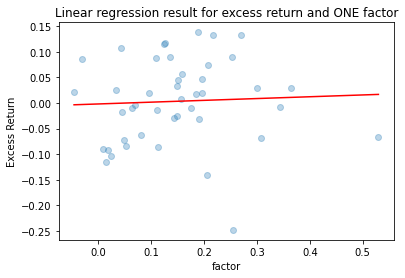

In [119]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def myPlot(factor, excessreturn, model):
    plt.scatter(factor, excessreturn, alpha=0.3)
    x = np.linspace(factor.min(), factor.max())
    y = model.predict(x.reshape(-1,1))
    plt.plot(x, y, color='r')
    plt.xlabel('factor')
    plt.ylabel('Excess Return')
    plt.title('Linear regression result for excess return and ONE factor')
    plt.show()

myPlot(x, y_BTC, BTC_fit)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


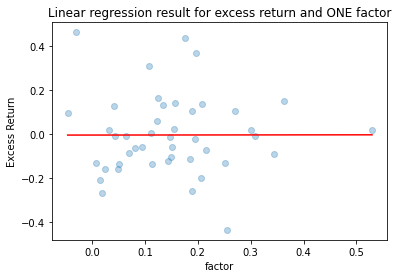

In [127]:
myPlot(x, y_AAVE, AAVE_fit)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


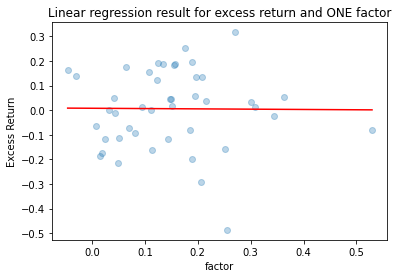

In [131]:
myPlot(x, y_ZRX, ZRX_fit)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


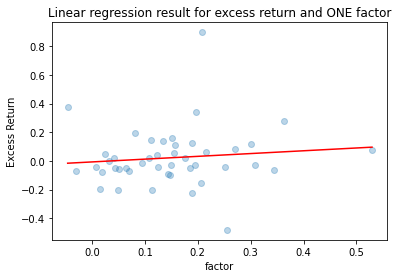

In [141]:
myPlot(x, y_ABT, ABT_fit)